# Real data application: Inverting the focal mechanism data set provided in Poyraz et al. 2015 (https://doi.org/10.1016/j.tecto.2015.06.022)

In [1]:
import os
import sys

# import the iterative linear stress inversion package
sys.path.append('/home/eric/Dropbox (MIT)/package_stress_inversion/ILSI')
import ILSI

import numpy as np
import h5py as h5
import pandas as pd
import matplotlib.pyplot as plt
from time import time as give_time

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colorbar as clb
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mplstereonet

# set plotting parameters
import seaborn as sns
sns.set()
sns.set_style('ticks')
sns.set_palette('colorblind')
#sns.set_context('paper')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['svg.fonttype'] = 'none'

# define the color palette
_colors_ = ['C0', 'C4', 'C1', 'C2']

## Load the data

Note: In Poyraz et al. 2015, the authors subdivide the data set into earthquakes that are part of the 17 August 1999 M7.6 Izmit earthquake, and those that occurred ~ 10 years later. The exact separation is not described in their manuscript so we might end up inverting slightly different data sets. In addition, I believe there is an inconsistency between the strike/dip/rake values reported for one of their earthquakes and the beachballs they plot, meaning there is either a typo in the data set I got, or they had a typo in the data set they inverted. Bearing that in mind, these small differences could not possibly explain large discrepancies between our inversions' results.

In [2]:
data_path = '/home/eric/Dropbox (MIT)/package_stress_inversion/ILSI/tests/data/'
data = pd.read_csv(os.path.join(data_path, 'data_Poyraz.csv'))
data['date'] = data['date'].str.strip()
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

data['strike'] = np.float32(data['strike'])
data['dip'] = np.float32(data['dip'])
data['rake'] = np.float32(data['rake'])

# subdivide the data set in two, as the authors did
data_Izmit = data[(data['date'] > '1999-08-16') & (data['date'] < '2004-01-01')]
data_DANA = data[data['date'] > '2011-01-01']


strikes_1 = data['strike'].values
dips_1 = data['dip'].values
rakes_1 = np.float32(data['rake'].values)%360.
n_earthquakes = len(strikes_1)
strikes_2, dips_2, rakes_2 = \
         np.asarray(list(map(ILSI.utils_stress.aux_plane, strikes_1, dips_1, rakes_1))).T

## Run the stress inversion

Running this script with the stress inversion parameters that I prodives takes ~ 10 minutes on my laptop.

In [9]:
# define the stress inversion routine
def stress_inversion(strikes_1, dips_1, rakes_1):
    t_start_experiment = give_time()
    n_earthquakes = len(strikes_1)
    strikes_2, dips_2, rakes_2 = \
         np.asarray(list(map(ILSI.utils_stress.aux_plane, strikes_1, dips_1, rakes_1))).T
    # --------------------------------
    #    stress tensor inversion
    # --------------------------------
    # inversion parameter
    friction_min = 0.1
    friction_max = 0.8
    friction_step = 0.05
    n_random_selections = 30
    n_stress_iter = 10
    n_resamplings = 1000
    n_averaging = 5
    ILSI_kwargs = {}
    ILSI_kwargs['max_n_iterations'] = 1000
    ILSI_kwargs['shear_update_atol'] = 1.e-7
    Tarantola_kwargs0 = {}
    # --------------------------------
    # initialize output dictionary
    # --------------------------------
    inversion_output = {}
    methods = ['linear', 'failure_criterion', 'iterative',
               'iterative_failure_criterion']
    for method in methods:
        inversion_output[method] = {}
        inversion_output[method]['stress_tensor'] =\
                np.zeros((3, 3), dtype=np.float32)
        inversion_output[method]['principal_stresses'] =\
                np.zeros(3, dtype=np.float32)
        inversion_output[method]['principal_directions'] =\
                np.zeros((3, 3), dtype=np.float32)
        inversion_output[method]['misfit'] = 0.
        inversion_output[method]['boot_stress_tensor'] =\
                np.zeros((n_resamplings, 3, 3), dtype=np.float32)
        inversion_output[method]['boot_principal_stresses'] =\
                np.zeros((n_resamplings, 3), dtype=np.float32)
        inversion_output[method]['boot_principal_directions'] =\
                np.zeros((n_resamplings, 3, 3), dtype=np.float32)
        inversion_output[method]['boot_misfit'] = np.zeros(n_resamplings, dtype=np.float32)
    inversion_output['iterative_failure_criterion']['friction'] = 0.
    inversion_output['failure_criterion']['friction'] = 0.
    Tarantola_kwargs = {}
    print(f'Linear inversion...')
    # simple, linear inversion
    inversion_output['linear']['stress_tensor'],\
    inversion_output['linear']['principal_stresses'],\
    inversion_output['linear']['principal_directions'] =\
            ILSI.ilsi.inversion_one_set(
                    strikes_1, dips_1, rakes_1,
                    n_random_selections=n_random_selections,
                    **ILSI_kwargs,
                    Tarantola_kwargs=Tarantola_kwargs,
                    iterative_method=False)
    print(f'Linear iterative inversion...')
    # Linear inversion for both the stress tensor and shear stresses
    inversion_output['iterative']['stress_tensor'],\
    inversion_output['iterative']['principal_stresses'],\
    inversion_output['iterative']['principal_directions'] =\
            ILSI.ilsi.inversion_one_set(
                    strikes_1, dips_1, rakes_1,
                    n_random_selections=n_random_selections,
                    **ILSI_kwargs,
                    Tarantola_kwargs=Tarantola_kwargs,
                    iterative_method=True)
    print(f'Failure criterion inversion...')
    inversion_output['failure_criterion']['stress_tensor'],\
    inversion_output['failure_criterion']['friction'],\
    inversion_output['failure_criterion']['principal_stresses'],\
    inversion_output['failure_criterion']['principal_directions'] =\
            ILSI.ilsi.inversion_one_set_instability(
                    strikes_1, dips_1, rakes_1,
                    n_random_selections=n_random_selections,
                    **ILSI_kwargs,
                    Tarantola_kwargs=Tarantola_kwargs,
                    friction_min=friction_min,
                    friction_max=friction_max,
                    friction_step=friction_step,
                    n_stress_iter=n_stress_iter,
                    n_averaging=n_averaging,
                    iterative_method=False)
    print(f'Linear iterative and failure criterion inversion...')
    inversion_output['iterative_failure_criterion']['stress_tensor'],\
    inversion_output['iterative_failure_criterion']['friction'],\
    inversion_output['iterative_failure_criterion']['principal_stresses'],\
    inversion_output['iterative_failure_criterion']['principal_directions'] =\
            ILSI.ilsi.inversion_one_set_instability(
                    strikes_1, dips_1, rakes_1,
                    n_random_selections=n_random_selections,
                    **ILSI_kwargs,
                    Tarantola_kwargs=Tarantola_kwargs,
                    friction_min=friction_min,
                    friction_max=friction_max,
                    friction_step=friction_step,
                    n_stress_iter=n_stress_iter,
                    n_averaging=n_averaging,
                    plot=False)
    for method in methods:
        R = ILSI.utils_stress.R_(inversion_output[method]['principal_stresses'])
        I, fp_strikes, fp_dips, fp_rakes = ILSI.ilsi.compute_instability_parameter(
                inversion_output[method]['principal_directions'], R, 0.6,
                strikes_1, dips_1, rakes_1, strikes_2, dips_2, rakes_2,
                return_fault_planes=True)
        inversion_output[method]['misfit'] =\
                np.mean(ILSI.utils_stress.mean_angular_residual(
                    inversion_output[method]['stress_tensor'],
                    fp_strikes, fp_dips, fp_rakes))
    print(f'Linear inversion (bootstrapping)...')
    # simple, linear inversion
    inversion_output['linear']['boot_stress_tensor'],\
    inversion_output['linear']['boot_principal_stresses'],\
    inversion_output['linear']['boot_principal_directions'] =\
            ILSI.ilsi.inversion_bootstrap(
                    strikes_1, dips_1, rakes_1,
                    n_resamplings=n_resamplings,
                    Tarantola_kwargs=Tarantola_kwargs,
                    iterative_method=False)
    print(f'Linear iterative inversion (bootstrapping)...')
    # Linear inversion for both the stress tensor and shear stresses
    inversion_output['iterative']['boot_stress_tensor'],\
    inversion_output['iterative']['boot_principal_stresses'],\
    inversion_output['iterative']['boot_principal_directions'] =\
            ILSI.ilsi.inversion_bootstrap(
                    strikes_1, dips_1, rakes_1,
                    n_resamplings=n_resamplings,
                    **ILSI_kwargs,
                    Tarantola_kwargs=Tarantola_kwargs,
                    iterative_method=True)
    print(f'Failure criterion inversion (bootstrapping)...')
    inversion_output['failure_criterion']['boot_stress_tensor'],\
    inversion_output['failure_criterion']['boot_principal_stresses'],\
    inversion_output['failure_criterion']['boot_principal_directions'] =\
            ILSI.ilsi.inversion_bootstrap_instability(
                    inversion_output['failure_criterion']['principal_directions'],
                    ILSI.utils_stress.R_(inversion_output['failure_criterion']['principal_stresses']),
                    strikes_1, dips_1, rakes_1,
                    inversion_output['failure_criterion']['friction'],
                    **ILSI_kwargs,
                    Tarantola_kwargs=Tarantola_kwargs,
                    n_stress_iter=n_stress_iter,
                    n_resamplings=n_resamplings,
                    iterative_method=False, verbose=0)
    print(f'Linear iterative and failure criterion inversion (bootstrapping)...')
    inversion_output['iterative_failure_criterion']['boot_stress_tensor'],\
    inversion_output['iterative_failure_criterion']['boot_principal_stresses'],\
    inversion_output['iterative_failure_criterion']['boot_principal_directions'] =\
            ILSI.ilsi.inversion_bootstrap_instability(
                    inversion_output['iterative_failure_criterion']['principal_directions'],
                    ILSI.utils_stress.R_(inversion_output['iterative_failure_criterion']['principal_stresses']),
                    strikes_1, dips_1, rakes_1,
                    inversion_output['iterative_failure_criterion']['friction'],
                    **ILSI_kwargs,
                    Tarantola_kwargs=Tarantola_kwargs,
                    n_stress_iter=n_stress_iter,
                    n_resamplings=n_resamplings,
                    iterative_method=True, verbose=0)
    for method in methods:
        for b in range(n_resamplings):
            R = ILSI.utils_stress.R_(inversion_output[method]['boot_principal_stresses'][b, ...])
            I, fp_strikes, fp_dips, fp_rakes = ILSI.ilsi.compute_instability_parameter(
                    inversion_output[method]['boot_principal_directions'][b, ...], R, 0.6,
                    strikes_1, dips_1, rakes_1, strikes_2, dips_2, rakes_2,
                    return_fault_planes=True)
            inversion_output[method]['boot_misfit'][b] =\
                    np.mean(ILSI.utils_stress.mean_angular_residual(
                        inversion_output[method]['boot_stress_tensor'][b, ...],
                        fp_strikes, fp_dips, fp_rakes))
    inversion_output['strikes'] = np.stack((strikes_1, strikes_2), axis=1)
    inversion_output['dips'] = np.stack((dips_1, dips_2), axis=1)
    inversion_output['rakes'] = np.stack((rakes_1, rakes_2), axis=1)
    t_end_experiment = give_time()
    print('Done! The inversion ran in {:.2f} seconds'.
         format(t_end_experiment-t_start_experiment))
    return inversion_output

def add_Poyraz_results(inversion_output):
    # Add Poyraz results: This is an approximate way of reconstructing
    # the stress tensor they obtained, because the azimuths and plunges 
    # they provide are not accurate enough to define three axes that are
    # perfectly orthogonal.
    # DANA
    inversion_output['DANA']['Poyraz'] = {}
    sig1_az, sig1_pl = 103, 27.
    sig2_az, sig2_pl = 256., 61.
    sig3_az, sig3_pl = 7., 11.
    R = 0.45
    st_DANA = build_stress_tensor(sig1_az, sig1_pl, sig2_az, sig2_pl, sig3_az, sig3_pl, R)
    ps, pd = ILSI.utils_stress.stress_tensor_eigendecomposition(st_DANA)
    I, fp_strikes, fp_dips, fp_rakes = ILSI.ilsi.compute_instability_parameter(
            pd, R, 0.6,
            strikes_1, dips_1, rakes_1, strikes_2, dips_2, rakes_2,
            return_fault_planes=True)
    misfit_P_faults = ILSI.utils_stress.mean_angular_residual(st_DANA, fp_strikes, fp_dips, fp_rakes)
    residuals_P = np.stack((ILSI.utils_stress.angular_residual(st_DANA, strikes_1, dips_1, rakes_1),
                            ILSI.utils_stress.angular_residual(st_DANA, strikes_2, dips_2, rakes_2)),
                            axis=1)
    best_misfit_P = np.mean(np.min(residuals_P, axis=-1))
    inversion_output['DANA']['Poyraz']['stress_tensor'] = st_DANA
    inversion_output['DANA']['Poyraz']['principal_directions'] = pd
    inversion_output['DANA']['Poyraz']['R'] = R
    inversion_output['DANA']['Poyraz']['misfit'] = misfit_P_faults
    # Izmit
    inversion_output['Izmit']['Poyraz'] = {}
    sig1_az, sig1_pl = 110., 0.
    sig2_az, sig2_pl = 201., 58.
    sig3_az, sig3_pl = 20., 32.
    R = 0.35
    st_Izmit = build_stress_tensor(sig1_az, sig1_pl, sig2_az, sig2_pl, sig3_az, sig3_pl, R)
    ps, pd = ILSI.utils_stress.stress_tensor_eigendecomposition(st_Izmit)
    I, fp_strikes, fp_dips, fp_rakes = ILSI.ilsi.compute_instability_parameter(
            pd, R, 0.6,
            strikes_1, dips_1, rakes_1, strikes_2, dips_2, rakes_2,
            return_fault_planes=True)
    misfit_P_faults = ILSI.utils_stress.mean_angular_residual(st_Izmit, fp_strikes, fp_dips, fp_rakes)
    residuals_P = np.stack((ILSI.utils_stress.angular_residual(st_Izmit, strikes_1, dips_1, rakes_1),
                            ILSI.utils_stress.angular_residual(st_Izmit, strikes_2, dips_2, rakes_2)),
                            axis=1)
    best_misfit_P = np.mean(np.min(residuals_P, axis=-1))
    inversion_output['Izmit']['Poyraz']['stress_tensor'] = st_Izmit
    inversion_output['Izmit']['Poyraz']['principal_directions'] = pd
    inversion_output['Izmit']['Poyraz']['R'] = R
    inversion_output['Izmit']['Poyraz']['misfit'] = misfit_P_faults

    
def build_stress_tensor(sig1_az, sig1_pl, sig2_az,
                        sig2_pl, sig3_az, sig3_pl, R):
    """
    Reconstruct stress tensor from azimuths and plunges of
    the principal stress axes, plus the value of the shape ratio R.
    """
    d2r = np.pi/180.
    u1_n = np.cos(sig1_az*d2r)*np.cos(sig1_pl*d2r)
    u1_w = -np.sin(sig1_az*d2r)*np.cos(sig1_pl*d2r)
    u1_z = np.sin(sig1_pl*d2r)
    u2_n = np.cos(sig2_az*d2r)*np.cos(sig2_pl*d2r)
    u2_w = -np.sin(sig2_az*d2r)*np.cos(sig2_pl*d2r)
    u2_z = np.sin(sig2_pl*d2r)
    u3_n = np.cos(sig3_az*d2r)*np.cos(sig3_pl*d2r)
    u3_w = -np.sin(sig3_az*d2r)*np.cos(sig3_pl*d2r)
    u3_z = np.sin(sig3_pl*d2r)
    sig1 = np.array([u1_n, u1_w, u1_z])
    sig2 = np.array([u2_n, u2_w, u2_z])
    sig3 = -np.array([u3_n, u3_w, u3_z])
    V = np.stack((sig1, sig2, sig3), axis=1)
    s1, s2, s3 = -1., 2*R-1., +1.
    S = np.diag(np.array([s1, s2, s3]) - np.sum([s1, s2, s3])/3.)
    S /= np.sqrt(np.sum(S**2))
    stress_tensor = np.dot(V, np.dot(S, V.T))
    return stress_tensor

def save_results(true_stress_tensor, inversion_output, filename):
    import h5py as h5
    with h5.File(filename, mode='w') as f:
        for key1 in inversion_output.keys():
            if isinstance(inversion_output[key1], dict):
                f.create_group(key1)
                for key2 in inversion_output[key1].keys():
                    f[key1].create_dataset(key2, data=inversion_output[key1][key2])
            else:
                f.create_dataset(key1, data=inversion_output[key1])
        f.create_dataset('true_stress_tensor', data=true_stress_tensor)

def read_results(filename):
    import h5py as h5
    inversion_output = {}
    with h5.File(filename, mode='r') as f:
        for key1 in f.keys():
            if isinstance(f[key1], h5.Dataset):
                inversion_output[key1] = f[key1][()]
            else:
                inversion_output[key1] = {}
                for key2 in f[key1].keys():
                    inversion_output[key1][key2] = f[key1][key2][()]
    return inversion_output['true_stress_tensor'], inversion_output

In [10]:
# run the inversion
inversion_output = {}
inversion_output['DANA'] = stress_inversion(
        data_DANA['strike'].values, data_DANA['dip'].values,
        np.float32(data_DANA['rake'].values)%360.)
inversion_output['Izmit'] = stress_inversion(
        data_Izmit['strike'].values, data_Izmit['dip'].values,
        np.float32(data_Izmit['rake'].values)%360.)
add_Poyraz_results(inversion_output)

Linear inversion...
Linear iterative inversion...
Failure criterion inversion...
-------- 1/5 ----------
Initial shape ratio: 0.35
----------
Stress tensor difference at iteration 0: 0.03961700658555076.
R=0.50, friction=0.60
Total instability: 0.73/Total differential instability: 0.36
Average angle: 47.21
Squared residuals: 4.37e-02
----------
Stress tensor difference at iteration 1: 0.001584828438704375.
R=0.51, friction=0.60
Total instability: 0.72/Total differential instability: 0.32
Average angle: 46.20
Squared residuals: 4.30e-02
----------
Stress tensor difference at iteration 2: 1.720288102524718e-17.
R=0.51, friction=0.60
Total instability: 0.72/Total differential instability: 0.32
Average angle: 46.20
Squared residuals: 4.30e-02
-------- 2/5 ----------
Initial shape ratio: 0.34
----------
Stress tensor difference at iteration 0: 0.04266702843141134.
R=0.50, friction=0.60
Total instability: 0.73/Total differential instability: 0.37
Average angle: 47.16
Squared residuals: 4.41e

Average angle: 45.71
Squared residuals: 2.02e-02
Final results:
Stress tensor:
 [[ 0.47648558 -0.07993987  0.03807044]
 [-0.07993987 -0.37553716  0.22874737]
 [ 0.03807044  0.22874737 -0.10094842]]
Shape ratio: 0.54
Linear inversion (bootstrapping)...
---------- Bootstrapping 1/1000 ----------
---------- Bootstrapping 101/1000 ----------
---------- Bootstrapping 201/1000 ----------
---------- Bootstrapping 301/1000 ----------
---------- Bootstrapping 401/1000 ----------
---------- Bootstrapping 501/1000 ----------
---------- Bootstrapping 601/1000 ----------
---------- Bootstrapping 701/1000 ----------
---------- Bootstrapping 801/1000 ----------
---------- Bootstrapping 901/1000 ----------
Linear iterative inversion (bootstrapping)...
---------- Bootstrapping 1/1000 ----------
---------- Bootstrapping 101/1000 ----------
---------- Bootstrapping 201/1000 ----------
---------- Bootstrapping 301/1000 ----------
---------- Bootstrapping 401/1000 ----------
---------- Bootstrapping 501/10

Initial shape ratio: 0.22
----------
Stress tensor difference at iteration 0: 0.06838143075238505.
R=0.41, friction=0.60
Total instability: 0.79/Total differential instability: 0.37
Average angle: 46.86
Squared residuals: 2.54e-02
----------
Stress tensor difference at iteration 1: 0.007913002726373316.
R=0.46, friction=0.60
Total instability: 0.74/Total differential instability: 0.29
Average angle: 44.97
Squared residuals: 2.51e-02
----------
Stress tensor difference at iteration 2: 0.006743324723489791.
R=0.38, friction=0.60
Total instability: 0.75/Total differential instability: 0.28
Average angle: 47.58
Squared residuals: 2.71e-02
----------
Stress tensor difference at iteration 3: 0.0.
R=0.38, friction=0.60
Total instability: 0.75/Total differential instability: 0.30
Average angle: 47.58
Squared residuals: 2.71e-02
-------- 5/5 ----------
Initial shape ratio: 0.18
----------
Stress tensor difference at iteration 0: 0.05620538727544244.
R=0.42, friction=0.60
Total instability: 0.83

NameError: name 'add_PT_axes' is not defined

## Plot the results

Define plotting routines and use them to reproduce the figures shown in the paper.

In [15]:
def plot_inverted_stress_tensors(inversion_output, axes=None, figtitle='', **kwargs):
    hist_kwargs = {}
    hist_kwargs['smoothing_sig'] = kwargs.get('smoothing_sig', 1)
    hist_kwargs['nbins'] = kwargs.get('nbins', 200)
    hist_kwargs['return_count'] = kwargs.get('return_count', True)
    hist_kwargs['confidence_intervals'] = kwargs.get('confidence_intervals', [95.])
    markers = ['o', 's', 'v']
    methods = ['linear', 'failure_criterion', 'iterative', 'iterative_failure_criterion']
    n_resamplings = inversion_output['linear']['boot_principal_directions'].shape[0]
    fig = plt.figure('inverted_stress_tensors_NAF', figsize=(18, 9))
    fig.suptitle(figtitle)
    gs2 = fig.add_gridspec(nrows=3, ncols=3, top=0.88, bottom=0.11,
                           left=0.20, right=0.80, hspace=0.4, wspace=0.7)
    axes = []
    ax1 = fig.add_subplot(gs2[0, 1], projection='stereonet')
    ax2 = fig.add_subplot(gs2[0, 2])
    ax3 = fig.add_subplot(gs2[0, 0], projection='stereonet')
    ax3.set_title('Nodal planes', pad=30)
    ax3.plane(inversion_output['strikes'][:, 0],
              inversion_output['dips'][:, 0], color='k', lw=1.0)
    for j, method in enumerate(methods):
        R = ILSI.utils_stress.R_(inversion_output[method]['principal_stresses'])
        for k in range(3):
            if j == 0:
                # add Poyraz's results
                az, pl = ILSI.utils_stress.get_bearing_plunge(
                        inversion_output['Poyraz']['principal_directions'][:, k])
                if k == 0:
                    label = 'Poyraz (FMSI):\n'
                    for k2 in range(3):
                        az, pl = ILSI.utils_stress.get_bearing_plunge(
                                inversion_output['Poyraz']['principal_directions'][:, k2])
                        label += r'$\sigma_{{{:d}}}$: {:.1f}'u'\u00b0''|{:.1f}'u'\u00b0'', '.\
                                format(k2+1, az, pl)
                    label += ' R={:.2f}, $\\vert{{\\Delta \\theta}}\\vert$={:.1f}'u'\u00b0'.\
                            format(inversion_output['Poyraz']['R'],
                                   inversion_output['Poyraz']['misfit'])
                else:
                    label = ''
                az, pl = ILSI.utils_stress.get_bearing_plunge(
                        inversion_output['Poyraz']['principal_directions'][:, k])
                ax1.line(pl, az, marker=markers[k], markeredgecolor='k', markeredgewidth=2,
                         markerfacecolor='none', markersize=15, label=label, zorder=2)
            if k == 0:
                label = '{}:\n'.format(method.replace('_', ' ').capitalize())
                for k2 in range(3):
                    az, pl = ILSI.utils_stress.get_bearing_plunge(
                            inversion_output[method]['principal_directions'][:, k2])
                    label += r'$\sigma_{{{:d}}}$: {:.1f}'u'\u00b0''|{:.1f}'u'\u00b0'', '.\
                            format(k2+1, az, pl)
                label += ' R={:.2f}, $\\vert{{\\Delta \\theta}}\\vert$={:.1f}'u'\u00b0'.\
                        format(R, inversion_output[method]['misfit'])
            else:
                label = ''
            az, pl = ILSI.utils_stress.get_bearing_plunge(
                    inversion_output[method]['principal_directions'][:, k])
            ax1.line(pl, az, marker=markers[k], markeredgecolor=_colors_[j], markeredgewidth=2,
                     markerfacecolor='none', markersize=[15, 15, 15, 15][j], label=label, zorder=2)
            boot_pd_stereo = np.zeros((n_resamplings, 2), dtype=np.float32)
            for b in range(n_resamplings):
                boot_pd_stereo[b, :] = ILSI.utils_stress.get_bearing_plunge(
                        inversion_output[method]['boot_principal_directions'][b, :, k])
            count, lons_g, lats_g, levels = ILSI.utils_stress.get_CI_levels(
                    boot_pd_stereo[:, 0], boot_pd_stereo[:, 1], **hist_kwargs)
            ax1.contour(lons_g, lats_g, count, levels=levels, vmin=0.,
                        linestyles=['solid', 'dashed', 'dashdot'][k],
                        linewidths=0.75, colors=_colors_[j], zorder=1.1)
        axes.append(ax1)
        Rs = np.zeros(n_resamplings, dtype=np.float32)
        for b in range(n_resamplings):
            Rs[b] = ILSI.utils_stress.R_(inversion_output[method]['boot_principal_stresses'][b, :])
        ax2.hist(Rs, range=(0., 1.), bins=20, lw=2.5, color=_colors_[j], histtype='step')
    ax2.set_xlabel('Shape Ratio')
    ax2.set_ylabel('Count')
    for ax in axes:
        #ax.grid(True)
        ax.legend(loc='upper left', bbox_to_anchor=(-0.5, -0.30))
    plt.subplots_adjust(top=0.88, bottom=0.11,
                        left=0.05, right=0.95,
                        hspace=0.4, wspace=0.4)
    return fig

In [12]:
# define some plotting parameters
kwargs = {}
kwargs['smoothing_sig'] = 5 # control the smoothness of the confidence intervals
kwargs['confidence_intervals'] = [95.]

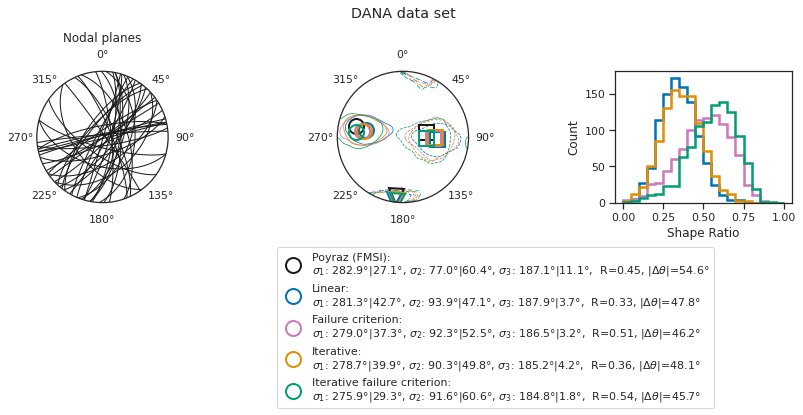

In [16]:
# plot figure for DANA data set
fig_DANA = plot_inverted_stress_tensors(inversion_output['DANA'], figtitle='DANA data set', **kwargs)

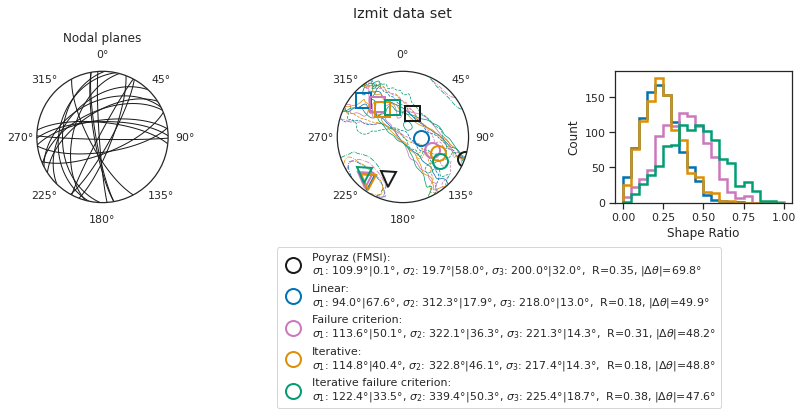

In [17]:
# plot figure for Izmit data set
fig_Izmit = plot_inverted_stress_tensors(inversion_output['Izmit'], figtitle='Izmit data set', **kwargs)